# Lab 3 — dimensionality reduction


**Group:** *J*

**Names:**
* *Ann-Kristin Bergmann*
* *Nephele Aesopou*
* *Ewa Miazga*


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

/opt/anaconda3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
import pickle

In [3]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [4]:
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads) # tagId, tag

In [5]:
scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads) # relevance, movieId, tagId

## Exercise 3.1

Construct an M ×N data matrix, where M is the number of tags and N the number of movies.
Do not include movies which do not have any tag.

First, we check that scores file and tags file have the same number of distinct tags. The scores file has 1128 distinct tags.


In [6]:
# Find distinct tag names & sorted by id
distinct_tags = tags.map(itemgetter('tag')).distinct().sortBy(lambda x:x).collect()

# Find distinct tag ids & sorted
distinct_tags_id = tags.map(itemgetter('tagId')).distinct().sortBy(lambda x:x).collect()

print("Number of distinct tags form tags:", len(distinct_tags)) #1128, so the number of files is the same.

Number of distinct tags form tags: 1128


In [7]:
# Group the scores RDD by movieId, sort them by the Id, and make tuples (tagId, relevance) for each movie.
movie_scores = scores.map(itemgetter('movieId', 'tagId', 'relevance')).groupBy(lambda x:x[0]).sortBy(lambda x: x[0])
movie_scores_collect = movie_scores.mapValues(lambda x: [(y[1],y[2]) for y in x]).collect()

In [8]:
# get a list of the distinct movie id in sorted order
movie_sorted_ids = [movie[0] for movie in movie_scores_collect]

In [9]:
# Count number of movies in order to make the matrix
movies_count = scores.map(itemgetter('movieId')).distinct().count()
print("Number of movies:", movies_count) #10381

Number of movies: 10381


Create the numpy matrix with entries of relevance accross movie and tag.

In [11]:
matrix = np.zeros((len(distinct_tags), movies_count))

# Build the matrix
for i, movieId in enumerate(movie_scores_collect):
    for tag in movieId[1]:
        matrix[tag[0]-1][i] = tag[1]
        
print(matrix.shape)        

(1128, 10381)


**  Plot the variance of each dimension (represented by tags) across all movies **

Text(0.5, 0, 'tagId')

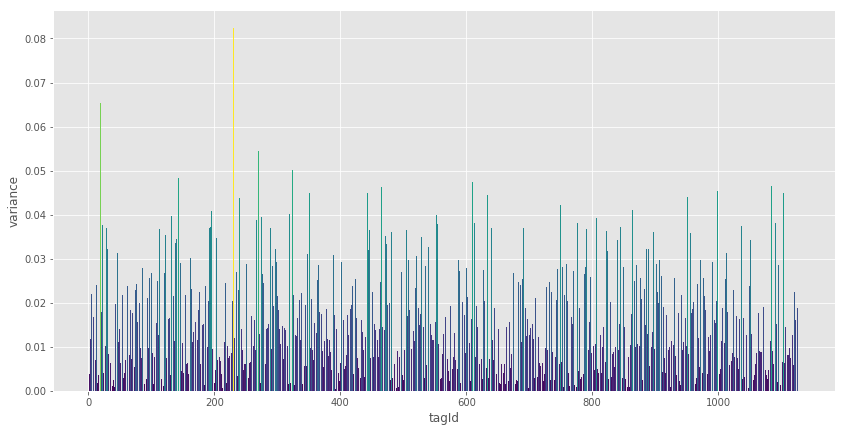

In [12]:
# Add colour to have a clearer understanding:
from matplotlib import cm
cmap = cm.get_cmap('viridis')

tag_variance = np.var(matrix, axis=1)
plt.figure(figsize=(14,7))
plt.bar(distinct_tags_id, tag_variance, color=cmap(tag_variance/np.max(tag_variance)))
plt.ylabel('variance')
plt.xlabel('tagId')

**Analysis of graph:**

In the above plot, the variance of each tag across all movies is plotted as a bar chart. The darker the color, the smaller the variance. Very few of the tags have variance over 0.4. This means that some tags provide more information than others. In PCA, our goal is to maximize the variance accross features, hence the tags with greater variance will provide more information. 

** Plot the eigenvalues of the M × M covariance matrix. **

In [13]:
# Center the M*N matrix by subracting the mean of each column (could also divide by std)
cols_mean = np.mean(matrix, axis = 1)
matrix_centered = matrix - cols_mean.reshape(-1,1)

In [14]:
# Calculate the M*M covariance matrix
cov = np.cov(matrix_centered)

In [15]:
# Get eigenvalues in ascending order
eigenvals, eigenvecs = np.linalg.eigh(cov)

# Sort the eigenvalues(with corresponding eigenvectors) in decreasing order
dec = np.flip(eigenvals.argsort())
eigenvals = eigenvals[dec]
eigenvecs = eigenvecs[:,dec]

Text(0, 0.5, 'Cumulative explained variance')

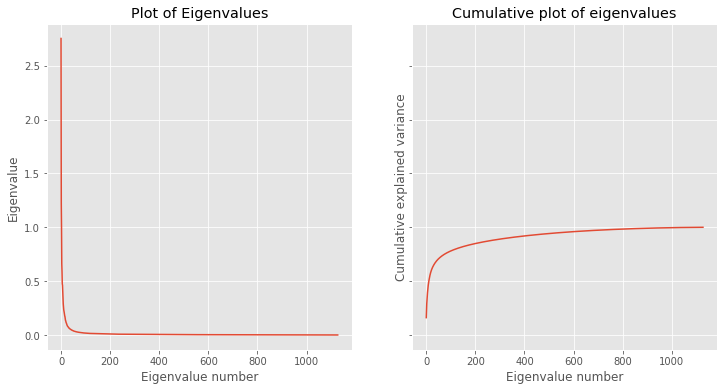

In [16]:
# Plot eigenvalues:
cum_sum = np.cumsum(eigenvals)
sum_eigen = np.sum(eigenvals)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
ax1.plot(np.arange(len(eigenvals)), eigenvals)
ax1.set_title("Plot of Eigenvalues")
ax1.set_xlabel("Eigenvalue number")
ax1.set_ylabel("Eigenvalue")

ax2.plot(np.arange(len(eigenvals)), cum_sum/ sum_eigen)
ax2.set_title("Cumulative plot of eigenvalues")
ax2.set_xlabel("Eigenvalue number")
ax2.set_ylabel("Cumulative explained variance")

**Explain the implications for dimensionality reduction.**

Looking at the left plot, we can understand that few eigenvalues are lare, while most of them are close to zero. From the right plot we can see that the explained variance of the principal components does not provide alot of information. Instead, less than the first 100 eigenvalues provide meaningful infromation. This may show when plotting the movies in their principal components.

For example, how many principal directions do you need to capture 2/3 of the variability in
the data? 

In [17]:
# compute the percentage of variance (information) accounted for by each component
exvar = (eigenvals)/ sum_eigen

print(f"PC1 accounts for {np.around(exvar[0]*100, decimals=2)}% of the variability.")
print(f"PC2 accounts for {np.around(exvar[1]*100, 2)}% of the variability.")
print(f"PC3 accounts for {np.around(exvar[2]*100, 2)}% of the variability.")

n_components = np.sum(np.cumsum(exvar) < 2/3) + 1
print(f"About 0.67 of the variability in the data is captured in: {n_components} components")

PC1 accounts for 16.1% of the variability.
PC2 accounts for 7.14% of the variability.
PC3 accounts for 5.82% of the variability.
About 0.67 of the variability in the data is captured in: 37 components


## Exercise 3.2 Concept space

In [18]:
top_five_pc = eigenvecs[:, :5]

# Find the indices that would sort the top five pc in ascending and descending order
lowest_indices = np.argsort(top_five_pc, axis=0)[:10, :]
highest_indices = np.argsort(top_five_pc, axis=0)[-10:, :]

In [19]:
# Find the 10 tags that have the highest and lowest coordinates in that direction (of the top five pc)
lowest_tags = [[distinct_tags[i] for i in indices] for indices in lowest_indices.T]
highest_tags = [[distinct_tags[i] for i in indices] for indices in highest_indices.T]

**What concepts would you use to describe these dimensions?**

In [20]:
print(highest_tags)

[['cinematography', 'dramatic', 'bleak', 'oscar (best directing)', 'drama', 'great acting', 'imdb top 250', 'criterion', 'social commentary', 'talky'], ['sexual', 'melancholy', 'art house', 'meditative', 'golden palm', 'loneliness', 'melancholic', 'criterion', 'relationships', 'intimate'], ['feel good movie', 'girlie movie', 'courage', 'sweet', 'romantic', 'touching', 'heartwarming', 'love story', 'sentimental', 'feel-good'], ['beautifully filmed', 'special effects', 'sci fi', 'science fiction', 'visually appealing', 'scifi', 'sci-fi', 'imagination', 'visually stunning', 'visual'], ['betrayal', 'murder mystery', 'investigation', 'suspense', 'mystery', 'tense', 'suspenseful', 'secrets', 'conspiracy', 'thriller']]


**1st Highest Tag**

       *Concept:* Award-winning Drama 

    'cinematography', 'dramatic', 'bleak', 'oscar (best directing)', 'drama', 'great acting', 'imdb top 250', 'criterion', 'social commentary', 'talky'


**2nd Highest Tag**

   *Concept:* Romantic Dramas

    'sexual', 'melancholy', 'art house', 'meditative', 'golden palm', 'loneliness', 'melancholic', 'criterion', 'relationships', 'intimate'


**3rd Highest Tag**

   *Concept:* Romance Movie

    'feel good movie', 'girlie movie', 'courage', 'sweet', 'romantic', 'touching', 'heartwarming', 'love story', 'sentimental', 'feel-good'


**4th Highest Tag**

   *Concept:* Science Fiction Movie

    'beautifully filmed', 'special effects', 'sci fi', 'science fiction', 'visually appealing', 'scifi', 'sci-fi', 'imagination', 'visually stunning', 'visual'


**5th Highest Tag**

   *Concept:* Mystery/Murder

    'betrayal', 'murder mystery', 'investigation', 'suspense', 'mystery', 'tense', 'suspenseful', 'secrets', 'conspiracy', 'thriller'

In [21]:
print(lowest_tags)

[['predictable', "so bad it's funny", 'bad plot', 'silly', 'silly fun', 'horrible', 'franchise', 'lame', 'big budget', 'comedy'], ['action', 'special effects', 'big budget', 'chase', 'fast paced', 'suspense', 'good action', 'plot', 'pg-13', 'action packed'], ['horror', 'weird', 'creepy', 'splatter', 'stylish', 'cult classic', 'disturbing', 'violence', 'cult film', 'dark'], ['corruption', 'crime', 'murder', 'police investigation', 'thriller', 'suspense', 'violence', 'police corruption', 'gangsters', 'manipulation'], ['comedy', 'funny', 'hilarious', 'goofy', 'humorous', 'humor', 'very funny', 'cult classic', 'quotable', 'funny as hell']]


**1st Lowest Tag**

   *Concept:* Silly comedy

    'predictable', "so bad it's funny", 'bad plot', 'silly', 'silly fun', 'horrible', 'franchise', 'lame', 'big budget', 'comedy'


**2nd Lowest Tag**

   *Concept:* Action movie

    'action', 'special effects', 'big budget', 'chase', 'fast paced', 'suspense', 'good action', 'plot', 'pg-13', 'action packed'


**3rd Lowest Tag**

   *Concept:* Scary movie

    'horror', 'weird', 'creepy', 'splatter', 'stylish', 'cult classic', 'disturbing', 'violence', 'cult film', 'dark'


**4th Lowest Tag**

   *Concept:* Crime movie

    'corruption', 'crime', 'murder', 'police investigation', 'thriller', 'suspense', 'violence', 'police corruption', 'gangsters', 'manipulation'


**5th Lowest Tag**

   *Concept:* Comedy

    'comedy', 'funny', 'hilarious', 'goofy', 'humorous', 'humor', 'very funny', 'cult classic', 'quotable', 'funny as hell'

Project the tags onto the coordinates of each pc. Each row is a movie and each column corresponds to a different principal direction.

In [22]:
tag_projection = matrix_centered.T @ top_five_pc

In [23]:
# get the tag ids for each eigenvectors
eigen_tags_id = np.argsort(top_five_pc, axis = 0)

# Get the corresponding tag names for the above
eigen_tags_name = [[distinct_tags[i] for i in indices] for indices in eigen_tags_id]

In [24]:
dictionary = {distinct_tags[i]: row for i, row in enumerate(top_five_pc)}

Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal
directions and save it to disk. This will be used later for the clustering exercise.

In [25]:
# Save the dictionary as csv.
import csv

# open file for writing, "w" is writing
w = csv.writer(open("output_3.2.csv", "w"))

# loop over dictionary keys and values
for key, val in dictionary.items():

    # write every key and value to file
    w.writerow([key, val[0], val[1], val[2], val[3], val[4]])

## Exercise 3.3 Movie Visualization


In [26]:
# For plotting

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

from matplotlib.colors import rgb2hex 
cmap = plt.get_cmap('viridis')

def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

Loading BokehJS ...

In [27]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    selected_movies = pickle.load(f, encoding="utf-8")

In [28]:
# Get two eigenvectors corresponding to the two largest eigenvalues
top_two_pc = eigenvecs[:, :2]

# I want to project the movies onto the coordinates of each pc
tag_projection = matrix_centered.T @ top_two_pc

In [29]:
# Make the data in order to plot it using bookeh
selected_movies_data_list = []

for i, movie in enumerate(selected_movies):
    
    # find the index of the movie in the matrix
    index = movie_sorted_ids.index(movie[0])
    
    # make tuple (x coordinate, y coordinate, movie title, RT score, i)
    new_tuple = (tag_projection[index][0],tag_projection[index][1], movie[1], movie[2], i )
    selected_movies_data_list.append(new_tuple)
    
# make into big tuple    
selected_movies_data = tuple(selected_movies_data_list)

In [30]:
# Plot the selected movies using continuous colours
source = ColumnDataSource(
    data={
        "x": [x[0] for x in selected_movies_data],
        "y": [x[1] for x in selected_movies_data],
        "name": [x[2] for x in selected_movies_data],
        "score": [x[3] for x in selected_movies_data],
        "color": [val2rgb(x[3]) for x in selected_movies_data],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
        ("Score", "@score")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=480, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
p.xaxis.axis_label='PC1'
p.yaxis.axis_label='PC2'
show(p, notebook_handle=True)

**Based on your knowledge of these movies and information that you can get from the web, explain the coordinates of a few of the movies.**

It is clear that the movies with the highest Rotten Tomatoes score (light colors) are mostly on the right of the plot, while movies with a bad rating (purple and blue colors) are mostly on the left. This means that the x-axis (PC1) is somewhat correlated with the movie score. Moreover, in the y-axis, the distinction is not as clear but on average, higher PC2 leads to a lower Rotten Tomato score.

If we consider the first principal component for the high rating movies (Award-winning Drama concept), we see that it aligns with the above graph, as to the left of the x-axis we find movies such as "City of God"-Drama/Crime (according to google), "American Beauty"-Drama/Romance and "Schindler's List'-War/Drama.
On the other hand, with the lowest x-axis value we find "Just my Luck" and "Miss Congeniality" which are both Silly comedy movies.

Considering the y-axis, the movies again confirm our previous calculations of the tags. Wih a high PC2 there are the romantic movies, such as "Wild Strawberries", while with a low PC2 its the action movies, such as "The Matrix".

**How do the PCA directions correlate with the Rotten Tomatoes score?**

The first Principal component (PC1) correlates significantly with the Rotten Tomatoes score. More specifically, they have a positive correlation as the higher the PC1, the higher the score.
On the contrary, the PC2 has a weaker correlation where the higher the PC2, the lower the score.

## Exercise 3.4 Movie visualization using t-SNE vs. PCA


In [31]:
# Get the top 5 tags for each movie
top_tags_per_movie = []
top_tags_names_per_movie = []

for movie in movie_scores_collect:
    movie = sorted(movie[1], key = lambda x : x[1], reverse=True)
    
    result_list = [t[0] for t in movie[:5]]
    top_tags_per_movie.append(result_list)
    
    result_names_list = [distinct_tags[distinct_tags_id.index(t)] for t in result_list]
    top_tags_names_per_movie.append(result_names_list)


Perform **t-SNE** with all movies

In [32]:
# Get eigenvectors of 50 larges eigenvalues
top_fifty_pc = eigenvecs[:, :50]
# I want to project the movies onto the coordinates of each pc
tag_projection_fifty = matrix_centered.T @ top_fifty_pc

In [33]:
tag_projection_fifty_embedded = TSNE(n_components=2, init = 'pca').fit_transform(tag_projection_fifty)

/opt/anaconda3.7/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/opt/anaconda3.7/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


In [34]:
# Make the data for plotting using bookeh
fifty_movies_data_list = []
for i, movie in enumerate(tag_projection_fifty_embedded):
    
    # make tuple (x coordinate, y coordinate, movie top five tags, i)
    new_tuple = (tag_projection_fifty_embedded[i][0], tag_projection_fifty_embedded[i][1], top_tags_names_per_movie[i], i )
    fifty_movies_data_list.append(new_tuple)
    
fifty_movies_data = tuple(fifty_movies_data_list)

In [35]:
# Pick a random selection of 1000 movies:
import random
random.seed(1)
sample = random.sample(fifty_movies_data, 1000)

In [40]:
def plot_bookeh_graph(data):
    
    source = ColumnDataSource(
        data={
            "x": [x[0] for x in data],
            "y": [x[1] for x in data],
            "name": [x[2] for x in data],
            #"color": [val2rgb(x[3]) for x in sample], no color distinction in this case.
        })

    hover = HoverTool(
        tooltips=[
            ("Name", "@name"),
        ])
    tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

    p = figure(plot_width=960, plot_height=720, tools=tools, title="Mouse over the dots")
    p.circle("x", "y", source=source, size=20, alpha=0.5)
    p.xaxis.axis_label='PC1'
    p.yaxis.axis_label='PC2'
    show(p, notebook_handle=True)

In [41]:
plot_bookeh_graph(sample)

Perform PCA of all movies

In [42]:
# Make the data in order to plot it using bookeh
all_movies_pca = random.sample(movie_scores_collect, 1000)
all_movies_data_list = []

for i, movie in enumerate(all_movies_pca):
    
    # find the index of the movie in the matrix
    index = movie_sorted_ids.index(movie[0])
    
    # make tuple (x coordinate, y coordinate, movie top five tags, i)
    new_tuple = (tag_projection[index][0],tag_projection[index][1],top_tags_names_per_movie[index], i )
    all_movies_data_list.append(new_tuple)
    
# make into big tuple    
all_movies_data = tuple(all_movies_data_list)

In [43]:
plot_bookeh_graph(all_movies_data)

**What differences do you observe between the t-SNE plot and the PCA plot? In particular,
in which of the plots do you see more interpretable clusters of movies? Can you explain
why?**

(Did not include movie titles because most of the times one cannot understand the tags/main concept from it)

Looking at the t-SNE plot, we can easily distinguish several main tag categories by hovering over the points. For example, in the centre (PC2=0) on the left there are the animation and disney movies, a bit more to the right the comedy movies and on the far right the political movies. Furthemore, looking at PC1=0, on the top are the horror movies, in the centre the romatinc and intimate movies while at the bottom there is a clear cluster of musical and boradway films.


On the other hand, the PCA plot is a bit more mixed between the categories and the points on the graph are not spread out as much. Hovering over the points and checking their top five tags, we see that on the bottom left there is a mixture of comedy and sci-fi movies, while with PC2 around 0 and PC1 around 4, we notice many drama films mixed with war-related films. There is still some idea of tag categories, but not as clear as in t-SNE.

This is the case because t-SNE uses Stochastic Neighborhood Embedding and assigns a probability to the movies depending on how close two movies are in the higher dimension.
Also, as we saw with our variance plot, the variance of the most tags is not high, hence, as PCA looks for high variance features, it does not perform as well with our dataset. Also, PCA works with linear data, while the tags are not.